In [1]:
import numpy as np
import nltk
import re
import pandas as pd 
import json
import os
import pickle
import csv
import matplotlib.pyplot as plt

from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from string import punctuation

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import spatial

from ast import literal_eval

from urllib.parse import urlparse

nltk.download('words')
th_stop = thai_stopwords()
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()

def split_word(text):
    tokens = word_tokenize(text,engine='newmm')
    
    # Remove stop words ภาษาไทย และอักขระพิเศษ
    tokens = [i for i in tokens if (not i in th_stop) & (not i in en_stop) & (not i in punctuation) & (not i in ["'",'"','“','”','‘','’','\n',"None", ' '])] 
    
    # ลบตัวเลข
    tokens = [i for i in tokens if not i.isnumeric()]
    
    # ลบช่องว่าง
    tokens = [i for i in tokens if not ' ' in i]

    return tokens

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


## ดึงข้อมูลของ cofact

### ดึงส่วนอ้างอิงของ cofact

In [2]:
def read_cofact_refer(): #สำหรับดึงข้อมูลของ cofact csv
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Cofact/cofact_refer_old.csv')
    
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)

    # read header from CSV file
    header = []
    header = next(csvreader)
    
    rows = []
    dup_check = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        
        # เพิ่ม header และตรวจสอบว่า header ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            tmp.append(row[1]) 

        # เพิ่ม content
        content_parts = literal_eval(row[2])
        content = ''.join(filter(None, content_parts))
        
        tmp.append(content)
        
        # เพิ่ม link (ข่าวต้นทางสุด)
        tmp.append(row[3])
        
        # เพิ่ม link (ลิงค์บนเว็บไซต์ cofact)
        tmp.append(row[5])
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [3]:
cofact_refer_text_list = read_cofact_refer()

In [4]:
cofact_refer_text_list

[['น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเชื่อ',
  'มีการแชร์ให้เห็นอยู่บ่อยว่า มีน้ำชาดื่มแล้วรักษาอาการแพ้อาหารได้ ซึ่งความเป็นจริงนั้นไม่สามารถทำได้ อาการแพ้อาหาร เป็นปฏิกิริยาตอบสนองของระบบภูมิคุ้มกันในร่างกายที่เกิดขึ้นหลังจากที่ผู้ป่วยรับประทานอาหารบางชนิดเข้าไป โดยอาจทำให้เกิดอาการที่มีความผิดปกติเกี่ยวกับทางเดินอาหารทางเดินหายใจ ผิวหนัง หรือระบบหลอดเลือดและหัวใจ ในบางรายอาจทำให้เกิดโรคภูมิแพ้ชนิดรุนแรงซึ่งมีอาการที่รุนแรงและอาจเป็นอันตรายถึงแก่ชีวิตได้',
  'https://sure.oryor.com/index.php/detail/media_specify/605',
  'https://cofact.org/article/18fondmkdx5t1'],
 ['มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อ',
  'เอาอีกแล้ว ไม่เช็คให้ชัวร์ แล้วก็แชร์กันไปมั่ว ๆ ว่า เอามะนาวกับเกลือมาถูหน้าผากแก้ไมเกรนได้ ความจริง การนำมะนาวหรือน้ำมะนาวหรือเกลือมาถูบริเวณหน้าผาก ไม่สามารถดูดซึมสารใดๆ ที่เป็นประโยชน์ในการบรรเทาอาการปวดไมเกรนเข้าสู่ร่างกายได้เลย นอกจากนี้ยังอาจเกิดการระคายเคืองที่ผิวหนังจากความเป็นกรดอ่อนๆของมะนาวได้',
  'https://sure.oryor.com/index.php/detail/media_specify/42

In [5]:
len(cofact_refer_text_list)

2050

### ดึงส่วนคนถามของ cofact

In [6]:
def read_cofact_info(): #สำหรับดึงข้อมูลของ cofact info csv
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Cofact/cofact_info_old.csv')
    
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)

    # read header from CSV file
    header = []
    header = next(csvreader)
    
    rows = []
    dup_check = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        # เพิ่ม ส่วนที่คนถาม (query) + ตรวจสอบว่า query ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            tmp.append(row[1])

        # เพิ่ม link (ลิงค์บนเว็บไซต์ cofact)
        tmp.append(row[3]) 
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [7]:
cofact_info_text_list = read_cofact_info()

In [8]:
cofact_info_text_list

[['หมอญี่ปุ่นพานักแสดงออกมาทดลองกลางรายการ ผมบางหนาขึ้นได้ เพราะกินสิ่งนี้ทุก ๆ วันติดต่อกัน 2 เดือน! (มีรูปเปรียบเทียบ) ',
  'https://cofact.org/article/1li9139uion6w'],
 ['ถ้าเราสามารถมีสาร CBD จากกัญชงได้ ผู้ป่วยโรคหอบหืดนับล้านคนทั่วโลก และในประเทศไทยไม่น้อย',
  'https://cofact.org/article/2resw1pb97bcc'],
 ['สำหรับกลุ่มที่ตรวจพบสารกันบูดเกินมาตรฐาน มีจำนวน 7 ตัวอย่าง ได้แก่',
  'https://cofact.org/article/iegselurn2op'],
 ['น้ำมะนาวร้อน รักษามะเร็ง', 'https://cofact.org/article/2xwlqnz7pav0l'],
 ['งานวิจัยเผย “เครื่องดื่มแอลกอฮอล์” มีผลดีต่อสุขภาพ',
  'https://cofact.org/article/1ukpajn9vmk8w'],
 ['ช่อง 9 เพิ่งออกข่าวภาคค่ำ วันนี้จ๊ะ.ตอนนี้พบ 11จังหวัด รวม',
  'https://cofact.org/article/1zlt4gkjoo3s3'],
 ['“สับปะรด”ทำลายเซลล์มะเร็ง ผลไม้มหัศจรรย์ ที่ไม่ควรมองข้าม !!',
  'https://cofact.org/article/eh9g8qnoveto'],
 ['โรตีดิบ', 'https://cofact.org/article/3qn3r3nxpsyi'],
 ['บ้านหมุนรักษาด้วยน้ำมะพร้าว', 'https://cofact.org/article/3w1687ii3e2rx'],
 ['ดื่มโซดากับนมเปรี้ยวก็ช่วยให้ลด

In [9]:
len(cofact_info_text_list)

3547

In [10]:
matched_list = []

for i in range(len(cofact_refer_text_list)):
    for j in range(len(cofact_info_text_list)):
        tmp = []
        if cofact_info_text_list[j][1] == cofact_refer_text_list[i][3]:
            tmp.append(cofact_info_text_list[j][0])
            tmp.append(cofact_refer_text_list[i][0])
            matched_list.append(tmp)

In [11]:
len(matched_list)

1704

In [12]:
matched_list

[['น้ำชา รักษาอาการแพ้อาหารได้',
  'น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเชื่อ'],
 ['เอามะนาวกับเกลือมาถูหน้าผาก แก้ไมเกรนได้',
  'มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อ'],
 ['พบการโฆษณาจำหน่ายผลิตภัณฑ์ NANO SILVER Sanitizer Water Spray ทางสื่อออนไลน์ว่า ช่วยฆ่าเชื้อโรค เชื้อไวรัสและแบคทีเรียได้มากกว่า 3,000 ชนิด สามารถฉีดใส่มาส์กได้โดยไม่ทำลายมาส์ก แถมยังช่วยเพิ่มประสิทธิภาพในการป้องกันและทำลายเชื้อโรค ฆ่าเชื้อโรคต่อเนื่องนาน 8-10 ชั่วโมง อีกทั้งช่วยลดสิว ผดผื่น อาการแพ้ตามผิวหนัง โดยได้การรับรองจากมหาวิทยาลัยและหน่วยงานต่างๆ',
  'อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสและแบคทีเรีย'],
 ['ดื่มกาแฟทำให้หน้าอกเล็กลง',
  'ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง '],
 ['นำปิโตรเลี่ยมเจลลี่มาทาคิ้ว แล้วคิ้วหนาขึ้นได้',
  'คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริง'],
 ['เชื้อ ‘ไวรัสโคโรนา’ อาจจะเป็นอาวุธชีวภาพที่คนสร้างขึ้นมา',
  'อย่าหลงเชื่อ! ‘อ.เจษฎ์’ ยัน ‘ไวรัสโคโรนา’ ถูกตัดต่อพันธุกรรมผสม HIV เป็นอาวุธชีวภาพ ไม่เป็นความจริง'],
 ['ช่อง 9 เพิ่งออกข่าวภาคค่ำ วันนี้จ๊ะ.ตอ

### นำ query ซ้ำใน matched list ออก

In [13]:
matched_list_dup_check = []
dup_del_matched_list = []

for query in matched_list:
    if query[0] in matched_list_dup_check:
        continue
    elif query[0] not in matched_list:
        matched_list_dup_check.append(query[0])
        dup_del_matched_list.append(query)

In [14]:
dup_del_matched_list

[['น้ำชา รักษาอาการแพ้อาหารได้',
  'น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเชื่อ'],
 ['เอามะนาวกับเกลือมาถูหน้าผาก แก้ไมเกรนได้',
  'มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อ'],
 ['พบการโฆษณาจำหน่ายผลิตภัณฑ์ NANO SILVER Sanitizer Water Spray ทางสื่อออนไลน์ว่า ช่วยฆ่าเชื้อโรค เชื้อไวรัสและแบคทีเรียได้มากกว่า 3,000 ชนิด สามารถฉีดใส่มาส์กได้โดยไม่ทำลายมาส์ก แถมยังช่วยเพิ่มประสิทธิภาพในการป้องกันและทำลายเชื้อโรค ฆ่าเชื้อโรคต่อเนื่องนาน 8-10 ชั่วโมง อีกทั้งช่วยลดสิว ผดผื่น อาการแพ้ตามผิวหนัง โดยได้การรับรองจากมหาวิทยาลัยและหน่วยงานต่างๆ',
  'อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสและแบคทีเรีย'],
 ['ดื่มกาแฟทำให้หน้าอกเล็กลง',
  'ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง '],
 ['นำปิโตรเลี่ยมเจลลี่มาทาคิ้ว แล้วคิ้วหนาขึ้นได้',
  'คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริง'],
 ['เชื้อ ‘ไวรัสโคโรนา’ อาจจะเป็นอาวุธชีวภาพที่คนสร้างขึ้นมา',
  'อย่าหลงเชื่อ! ‘อ.เจษฎ์’ ยัน ‘ไวรัสโคโรนา’ ถูกตัดต่อพันธุกรรมผสม HIV เป็นอาวุธชีวภาพ ไม่เป็นความจริง'],
 ['ช่อง 9 เพิ่งออกข่าวภาคค่ำ วันนี้จ๊ะ.ตอ

In [15]:
len(dup_del_matched_list)

1611

## ดึงส่วนอ้างอิงของ anti-fake news

In [16]:
def read_anti_refer(): #สำหรับดึงข้อมูลของ anti fake news csv
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Anti/anti_info.csv')
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)
    
    # read header from CSV file
    header = []
    header = next(csvreader)

    rows = []
    dup_check = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        
        # เพิ่ม header และตรวจสอบว่า header ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            tmp.append(row[1]) 
        
        # เพิ่ม content
        content_parts = literal_eval(row[2])
        content = ''.join(filter(None, content_parts))
        tmp.append(content)
        
        # เพิ่ม link
        tmp.append(row[3])
        
        # เพิ่ม datetime
        tmp.append(row[5])
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [17]:
anti_refer_text_list = read_anti_refer()

## ดึงส่วนอ้างอิงของ sure and share

In [18]:
def read_sure_refer(): #สำหรับดึงข้อมูลของ sure and share csv
    # Opening CSV file
    root_path = os.getcwd()
    path = os.path.join(root_path, '../result/Sure/sure_info.csv')
    f = open(path, encoding="utf8")
    
    # returns CSV object as
    # a dictionary
    csvreader = csv.reader(f)
    
    # read header from CSV file
    header = []
    header = next(csvreader)

    rows = []
    dup_check = []
    
    for row in csvreader:
        tmp = []
        
        content_parts = []
        content = ''
        
        # เพิ่ม header + content และตรวจสอบว่า header ซ้ำหรือไม่
        if row[1] in dup_check:
            continue
        
        elif row[1] not in dup_check:
            dup_check.append(row[1])
            tmp.append(row[1]) 
        
        # เพิ่ม content
        content_parts = literal_eval(row[2])
        content = ''.join(filter(None, content_parts))
        tmp.append(content)
        
        # เพิ่ม link
        tmp.append(row[3])
        
        # เพิ่ม datetime
        tmp.append(row[5])
        
        rows.append(tmp)

    # Closing file
    f.close()
    
    return rows

In [19]:
sure_refer_text_list = read_sure_refer()

In [20]:
all_refer_text_list = []
all_refer_text_list = cofact_refer_text_list + anti_refer_text_list + sure_refer_text_list

In [21]:
len(all_refer_text_list)

6357

## ------------------------------------------------------------------------------
## สร้าง dataframe ของ cofact สำหรับอ้างถึงตอนแนบลิงค์ url แสดงผล

In [22]:
all_refer_header = []
all_refer_content = []
all_refer_url = []
all_refer_datetime = []
all_refer_domain = []

for i in range(len(all_refer_text_list)):
    all_refer_header.append(all_refer_text_list[i][0]) #list ของส่วนหัวข้อข่าว
    all_refer_content.append(all_refer_text_list[i][1]) #list ของส่วนเนื้อหาเท่านั้น
    all_refer_url.append(all_refer_text_list[i][2]) #list ของ url เท่านั้น
    all_refer_datetime.append(all_refer_text_list[i][3]) #list ของ datetime เท่านั้น
    all_refer_domain.append(urlparse(all_refer_text_list[i][2]).hostname) #list ของ domain เท่านั้น


In [23]:
#ทำ list ให้เป็น dataframe
all_original_text_and_headline_news_df = pd.DataFrame(list(zip(all_refer_header, all_refer_content, all_refer_url, all_refer_datetime, all_refer_domain)), columns=["All_headline_from_every_reference", "All_content_from_every_reference", "All_URL_from_every_reference", "All_datatime_from_every_reference", "All_domain_from_every_reference"])

all_original_text_and_headline_news_df

All_headline_from_every_reference  \
0     น้ำชาไม่สามารถรักษาโรคแพ้อาหารได้ โปรดอย่าหลงเ...   
1               มะนาวเกลือแก้ไมเกรน มั่วมาก อย่าไปเชื่อ   
2     อย่าหลงเชื่อ “นาโน สเปรย์” อ้างฆ่าเชื้อไวรัสแล...   
3         ดื่มกาแฟวันละสามแก้วทำให้หน้าอกเล็กลงไม่จริง    
4            คิ้วดกดำด้วยการทาปิโตรเลียม เจลลี่ ไม่จริง   
...                                                 ...   
6352  ชัวร์ก่อนแชร์: นอร์เวย์เปิดประเทศ หลังพบโควิดอ...   
6353  ชัวร์ก่อนแชร์: เนเธอร์แลนด์เอาชนะโควิด ด้วย Hy...   
6354  ชัวร์ก่อนแชร์: ยุโรปแบนคนอายุน้อยฉีดวัคซีน Mod...   
6355  ชัวร์ก่อนแชร์: วัคซีนโควิด 19 ทำให้เลือดเปลี่ย...   
6356  ชัวร์ก่อนแชร์: อินโดนีเซียฟื้นตัวจากโควิดเพราะ...   

                       All_content_from_every_reference  \
0     มีการแชร์ให้เห็นอยู่บ่อยว่า มีน้ำชาดื่มแล้วรัก...   
1     เอาอีกแล้ว ไม่เช็คให้ชัวร์ แล้วก็แชร์กันไปมั่ว...   
2     อย. เตือน!! อย่าหลงเชื่อผลิตภัณฑ์ NANO SILVER ...   
3     กาแฟเป็นเครื่องดื่มที่นิยมอย่างแพร่หลายทั่วโลก...   
4     แชร์ทั่วอินเทอร์เน็ตว่า มีคนนำปิโตรเลียม เจลลี...   
...                                                 ...   
6352  10 มกราคม 2564ตรวจสอบข้อเท็จจริงโดย: Politifac...   
6353  11 มกราคม 2564ตรวจสอบข้อเท็จจริงโดย: Myth Dete...   
6354  12 มกราคม 2564ตรวจสอบข้อเท็จจริงโดย: Politifac...   
6355  14 มกราคม 2564ตรวจสอบข้อเท็จจริงโดย: Dogrulukp...   
6356  15 มกราคม 2564ตรวจสอบข้อเท็จจริงโดย: Science F...   

                           All_URL_from_every_reference  \
0     https://sure.oryor.com/index.php/detail/media_...   
1     https://sure.oryor.com/index.php/detail/media_...   
2     https://oryor.com/%E0%B8%AD%E0%B8%A2/detail/me...   
3     https://sure.oryor.com/index.php/detail/media_...   
4     https://sure.oryor.com/index.php/detail/media_...   
...                                                 ...   
6352            https://tna.mcot.net/latest-news-858477   
6353            https://tna.mcot.net/latest-news-859101   
6354            https://tna.mcot.net/latest-news-859860   
6355            https://tna.mcot.net/latest-news-861367   
6356            https://tna.mcot.net/latest-news-862183   

             All_datatime_from_every_reference All_domain_from_every_reference  
0     https://cofact.org/article/18fondmkdx5t1                  sure.oryor.com  
1      https://cofact.org/article/rzoplz5v22rb                  sure.oryor.com  
2     https://cofact.org/article/110yfgvyqqj5d                       oryor.com  
3     https://cofact.org/article/2wmt8eex5xqcg                  sure.oryor.com  
4     https://cofact.org/article/288f0qlim28fh                  sure.oryor.com  
...                                        ...                             ...  
6352                          10/01/2565 08:40                    tna.mcot.net  
6353                          11/01/2565 03:55                    tna.mcot.net  
6354                          12/01/2565 05:55                    tna.mcot.net  
6355                          14/01/2565 04:15                    tna.mcot.net  
6356                          15/01/2565 07:06                    tna.mcot.net  

[6357 rows x 5 columns]

In [24]:
all_headline_tokens_list = [split_word(txt) for txt in all_refer_header] #นำ list ของหังข้อข่าวมาตัดคำ

In [25]:
all_tokens_list_j = [','.join(tkn) for tkn in all_headline_tokens_list]

----------------------------------------------------------------------------------
# สร้าง vocabulary set

In [26]:
print(all_tokens_list_j[0].split(",")[0:2])


['น้ำชา', 'รักษาโรค']


In [27]:
## Create Vocabulary
tokens_list = []

for words in all_tokens_list_j:
    # print(words)
    temp_list = words.split(",")
    # print(temp_list)
    for i in temp_list:
        tokens_list.append(i)

vocabulary = set(tokens_list)
vocabulary = list(vocabulary)

In [28]:
len(vocabulary)

7206

--------------------------------------------------------------------------------------

In [29]:
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
original_c_feat = tvec.fit_transform(all_tokens_list_j)

### Save Trained TFID Model

In [30]:
### Save model
root_path = os.getcwd()
path = os.path.join(root_path, 'all-tfid.pkl')
print(path)
with open(path,'wb') as handle:
    pickle.dump(original_c_feat, handle)

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\all-tfid.pkl


In [31]:
### load model
root_path = os.getcwd()
path = os.path.join(root_path, 'all-tfid.pkl')
print(path)
t = pickle.load(open(path,'rb'))

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\all-tfid.pkl


### Save Vocabulary

In [32]:
### Save Vacabulary
root_path = os.getcwd()
path = os.path.join(root_path, 'vocabulary_all.txt')
print(path)
with open(path, "w", encoding="utf-8") as file:
    file.write(str(vocabulary))

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\vocabulary_all.txt


In [33]:
### load Vacabulary
root_path = os.getcwd()
path = os.path.join(root_path, 'vocabulary_all.txt')
print(path)
with open(path, "r", encoding="utf-8") as file:
    data2 = eval(file.readline())

c:\Users\Administrator\Documents\SeniorProject\Senior-project\Preprocess\vocabulary_all.txt


In [34]:
data2

['',
 'อุ่น',
 'แป้งฝุ่น',
 'ชมพู',
 'ไลน์',
 'เหา',
 'เข็ม',
 'น.ศ.',
 'อบ',
 'ปัตตานี',
 'นครพนม',
 'เกินขนาด',
 'เศรษฐ',
 'โรคมะเร็ง',
 'แย่',
 'ระบบประสาทอัตโนมัติ',
 'ยศ',
 'เก็บภาษี',
 'แฉ',
 'บิ',
 'GBS',
 'พฤษภาคม',
 'Hunter',
 'ลุง',
 'รสนิยม',
 'Tea',
 'เชียง',
 'น้ำคำ',
 'ถู',
 'ยางมะตอย',
 'บขส.',
 'ผู้ค้า',
 'เปอร์เซ็นต์',
 'ล้างจาน',
 'Pantoflex',
 'Mix',
 'ประชวร',
 'วิธีวัด',
 '18.00',
 'สถานทูต',
 'กลายพันธุ์',
 'Street',
 'มะแว้ง',
 'ตุ๊กตุ๊ก',
 'ควรจะ',
 'ต่าย',
 'ถาวร',
 'ความสัมพันธ์',
 'กัมมันตภาพรังสี',
 'กม.',
 'แม่ลูกอ่อน',
 'ช็อป',
 'ปลัดขิก',
 'สาวน้อย',
 'มาสู่',
 'จอง',
 'ความจำเสื่อม',
 'MANA',
 'สวิง',
 'ออน',
 'ทั้งเมือง',
 'จับได้',
 'ปรับเปลี่ยน',
 'AVF',
 'อาสาฬหบูชา',
 'End',
 'สวนยาง',
 'ไร้ประโยชน์',
 'ลงดาบ',
 'ขุน',
 'งา',
 'วิจัย',
 'ยิ้ม',
 'กระเพาะปัสสาวะ',
 'ออกหมายจับ',
 'คาวาซากิ',
 'โควต้า',
 'ใส่กุญแจ',
 'มีประสิทธิผล',
 'แฮปปี้',
 'ถอดความ',
 'ไตร',
 'วันหมดอายุ',
 'Vikill',
 'บูรณาการ',
 'MyMo',
 'Start',
 'เหวี่ยง',
 'มรสุม',
 'สหกรณ์'

In [35]:
len(data2)

7206

## Create vector for Query/search keywords

In [36]:
## Create vector for Query/search keywords
def gen_vector_T(tokens):

    Q = np.zeros((len(vocabulary)))
    
    x = tvec.transform(tokens)
    
    x = x.A[0]
    return x

### Calculate Cosine similarity of trained Tfidf to input query


In [37]:
norm_original_c_feat = normalize(original_c_feat)
norm_original_c_feat = norm_original_c_feat.toarray()
norm_original_c_feat = norm_original_c_feat.T

In [38]:
query_vector = []
def cosine_similarity_T(k, query):
    tokens = split_word(str(query))
    q_df = pd.DataFrame(columns=['q_clean'])
    q_df.loc[0,'q_clean'] =str(tokens)

    q_df=q_df.replace(to_replace ="\[.", value = '', regex = True)
    q_df=q_df.replace(to_replace ="'", value = '', regex = True)
    q_df=q_df.replace(to_replace =" ", value = '', regex = True)
    q_df=q_df.replace(to_replace ='\]', value = '', regex = True)
    
    d_cosines = []
    
    query_vector = gen_vector_T(q_df['q_clean'])
    query_vector = query_vector.reshape((1,-1))

    d_cosines = np.dot(normalize(query_vector),norm_original_c_feat)
    
    list_d_cosines = d_cosines[0].tolist()
    
    out = np.array(list_d_cosines).argsort()[-k:][::-1]

    list_d_cosines.sort()
    a = pd.DataFrame()
    for i in out:
        a.loc[i,'index'] = str(i)
        a.loc[i,'headline'] = all_original_text_and_headline_news_df["All_headline_from_every_reference"][i]

    list_d_cosines.sort(reverse=True)
    
    for j in range(k):
        a.loc[out[j],'Score'] = list_d_cosines[j]
        
    return a

In [39]:
query = "สิ้นเดือนนี้ คิงส์พาวเวอร์ ปิดทุกสาขา ไม่มีกำหนด ยกเว้นสนามบิน สำนักงานใหญ่ซอยรางน้ำ ในยามปกติ ขายได้วันละ 50 ล้านบาท ตอนนี้ทุกวันขายได้วันละ 20,000 บาท"

In [40]:
%time all_result = cosine_similarity_T(30, query)

Wall time: 89 ms


In [41]:
all_result

index                                           headline     Score
1310  1310       ข่าวปลอม คิงเพาเวอร์ ปิดทุกสาขาสิ้นเดือนนี้   0.353714
1311  1311  “คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่า...  0.258120
1444  1444  เช็ก! จังหวัดไหนบ้าง ไม่ใส่หน้ากากออกจากบ้าน ป...  0.213533
3052  3052  ข่าวปลอม อย่าแชร์! ปี 64 รัฐบาลเตรียมกู้เงินเพ...  0.182731
2547  2547  ข่าวปลอม อย่าแชร์! แชร์สนั่น รัฐบาลประมูลขายชุ...  0.176441
2651  2651  ข่าวปลอม อย่าแชร์!  ข่าวด่วน! ไทยแพ้คดีคิงส์เก...  0.170504
2642  2642  ข่าวปลอม อย่าแชร์! แจกเงินเยียวยาครอบครัวละ 1 ...  0.167685
3446  3446  ข่าวปลอม อย่าแชร์! ออมสิน เปิดกู้สินเชื่อบ้าน ...  0.166728
3742  3742  ข่าวปลอม อย่าแชร์! ศูนย์ฉีดวัคซีนกลางบางซื่อ ม...  0.165749
4024  4024  ข่าวปลอม อย่าแชร์! ขายหมูที่แผงตนเอง ต้องนำหมู...  0.160302
3642  3642  ราชกิจจานุเบกษาประกาศไม่สวมหน้ากากอนามัย-หน้าก...  0.156413
3909  3909  ข่าวบิดเบือน คนพิการที่ติดโควิด-19 ได้รับการช่...  0.154212
2358  2358  ข่าวปลอม อย่าแชร์! ตัดงบบัตรทองจาก 13,000 ล้าน...  0.152887
4062  4062  ข่าวปลอม อย่าแชร์! ธ.ออมสิน เปิดสินเชื่อให้กู้...  0.152210
4483  4483  ข่าวปลอม อย่าแชร์! ธ.ออมสิน ให้กู้ซื้อบ้าน 1 ล...  0.149235
3494  3494  ข่าวบิดเบือน ธ. ออมสิน ปล่อยสินเชื่อ 200,000 บ...  0.146148
3992  3992  ข่าวบิดเบือน ธ.กรุงไทย ปล่อยสินเชื่อให้กู้ยืม ...  0.145338
4505  4505  ข่าวปลอม อย่าแชร์! ข้อมูลผู้ป่วยรพ. ศิริราชกว่...  0.145311
3321  3321  ข่าวปลอม อย่าแชร์! ธ.ก.ส. เปิดกู้สินเชื่อสำหรั...  0.144810
4122  4122  ข่าวปลอม อย่าแชร์! ธ.ออมสิน ปล่อยสินเชื่อให้กู...  0.143796
3195  3195  ข่าวปลอม อย่าแชร์! เราไม่ทิ้งกันรอบใหม่รับ 8,0...  0.143426
3063  3063  ข่าวปลอม อย่าแชร์! ประเทศไทยติดหนี้สาธารณะจำนว...  0.143408
3702  3702  ข่าวปลอม อย่าแชร์! ธนาคารออมสิน เปิดให้ยืม 50,...  0.143277
2318  2318  ธ.ก.ส. สาขาพญาแล และสาขาหนองกี่ โอนเงินช่วยเหล...  0.142750
3353  3353  ข่าวปลอม อย่าแชร์! ธนาคารออมสินให้กู้ฉุกเฉิน 1...  0.141968
1019  1019   เริ่มแล้ว สมอ.ควบคุมผลิต-จำหน่าย “พาวเวอร์แบงก์”  0.139104
4920  4920  ชัวร์ก่อนแชร์ : เว็บไซต์ขายยาเพื่อสุขภาพ เชื่อ...  0.137177
4766  4766  ชัวร์ก่อนแชร์ : ยากำจัดพยาธิ ขายออนไลน์ ใช้ได้...  0.136416
2153  2153  11 ส.ค. 63 ปรับเกณฑ์ใหม่ ‘คุ้มครองเงินฝาก’ จาก...  0.134369
4561  4561  ชัวร์ก่อนแชร์ : คลิปคนขายทุเรียนถ่มน้ำลาย จริง...  0.133332

In [42]:
all_result.iloc[1]['headline']

'“คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่าวเท็จ! รางน้ำ-พัทยา-ภูเก็ตเปิดตามปกติ'

In [43]:
# dup_del_matched_list[4][1]

In [44]:
all_result.iloc[:10]['headline']

1310         ข่าวปลอม คิงเพาเวอร์ ปิดทุกสาขาสิ้นเดือนนี้ 
1311    “คิง เพาเวอร์” แจงข้อความว่อน “ปิดทุกสาขา” ข่า...
1444    เช็ก! จังหวัดไหนบ้าง ไม่ใส่หน้ากากออกจากบ้าน ป...
3052    ข่าวปลอม อย่าแชร์! ปี 64 รัฐบาลเตรียมกู้เงินเพ...
2547    ข่าวปลอม อย่าแชร์! แชร์สนั่น รัฐบาลประมูลขายชุ...
2651    ข่าวปลอม อย่าแชร์!  ข่าวด่วน! ไทยแพ้คดีคิงส์เก...
2642    ข่าวปลอม อย่าแชร์! แจกเงินเยียวยาครอบครัวละ 1 ...
3446    ข่าวปลอม อย่าแชร์! ออมสิน เปิดกู้สินเชื่อบ้าน ...
3742    ข่าวปลอม อย่าแชร์! ศูนย์ฉีดวัคซีนกลางบางซื่อ ม...
4024    ข่าวปลอม อย่าแชร์! ขายหมูที่แผงตนเอง ต้องนำหมู...
Name: headline, dtype: object

## วัดความแม่นยำการค้นคืนด้วยจำนวนข่าวที่ต่างกัน (ข่าวที่มี similarity สูงสุด 1, 3, 5, 10 ข่าว)

In [45]:
top_1 = 0
top_3 = 0
top_5 = 0
top_10 = 0
top_30 = 0

missing_query_count = 0

not_matched = []

for user_input in range(len(dup_del_matched_list)):
    tmp = []
    top3_tmp = []
    if dup_del_matched_list[user_input][0] == '':
        # print("Missing query")
        missing_query_count += 1
        continue
    
    all_result = cosine_similarity_T(20, dup_del_matched_list[user_input][0])
    
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']):
        top_1 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']):
        top_3 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline']):
        top_5 += 1
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[5]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[6]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[7]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[8]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[9]['headline']):
        top_10 += 1
    # if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[5]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[6]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[7]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[8]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[9]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[10]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[11]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[12]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[13]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[14]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[15]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[16]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[17]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[18]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[19]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[20]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[21]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[22]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[23]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[24]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[25]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[26]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[27]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[28]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[29]['headline']):
    #     top_30 += 1
    else:
        tmp.append(dup_del_matched_list[user_input][0])
        tmp.append(dup_del_matched_list[user_input][1])
        
        for i in range(20):
            tmp.append(all_result.iloc[i]['headline'])
            
        not_matched.append(tmp)

In [46]:
missing_query_count

0

In [47]:
top_1

828

In [48]:
top_3

1097

In [49]:
top_5

1179

In [50]:
top_10

1273

In [51]:
len(dup_del_matched_list)

1611

In [52]:
top_10/(len(dup_del_matched_list) - missing_query_count)

0.7901924270639354

In [53]:
not_matched

[['เชื้อ ‘ไวรัสโคโรนา’ อาจจะเป็นอาวุธชีวภาพที่คนสร้างขึ้นมา',
  'อย่าหลงเชื่อ! ‘อ.เจษฎ์’ ยัน ‘ไวรัสโคโรนา’ ถูกตัดต่อพันธุกรรมผสม HIV เป็นอาวุธชีวภาพ ไม่เป็นความจริง',
  'ชัวร์ก่อนแชร์ FACTSHEET : ไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'ชัวร์ก่อนแชร์ FACTSHEET : ไวรัสโคโรนาติดเชื้อผ่านดวงตาได้ จริงหรือ?',
  'คลิปสุดช็อค! ไวรัสโคโรนา ทำคนล้มทั้งยืน  ข่าวปลอม สร้างความเข้าใจผิด อย่าแชร์!',
  'ชัวร์ก่อนแชร์ FACTSHEET : กินอะไร? ช่วยป้องกันไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'ชัวร์ก่อนแชร์ FACTSHEET : ไวรัสโคโรนาในสุนัขและแมว',
  'ชัวร์ก่อนแชร์ FACTSHEET : มีการจดสิทธิบัตรไวรัสโคโรนาไว้แล้ว จริงหรือ?',
  'ข่าวปลอม อย่าแชร์! พบคนไทยเสียชีวิต 1 คน ติดไวรัสโคโรนามาจากเชียงใหม่',
  'ชัวร์ก่อนแชร์ FACTSHEET : การรักษาและป้องกันไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'ชัวร์ก่อนแชร์ FACTSHEET : “ไข้หวัดใหญ่” เทียบ “โคโรนาไวรัส 2019”',
  'พัทยาพบผู้ป่วยเสียชีวิตจากไวรัสโคโรนา 1 ราย ข่าวปลอมสร้างความปั่นป่วน\u200b หยุดแชร์!',
  'ชัวร์ก่อนแชร์ FACTSHEET : หน้ากาก-อาหารป้องกันไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'อย่

In [54]:
len(not_matched)

338

In [55]:
top_10 + len(not_matched)

1611

In [56]:
len(dup_del_matched_list) - missing_query_count

1611

### Find fixed threshold

In [57]:
missing_query_count = 0

not_matched = []
each_query_score = []

for user_input in dup_del_matched_list:
    tmp = []
    if user_input[0] == '':
        # print("Missing query")
        missing_query_count += 1
        continue
    
    all_result = cosine_similarity_T(20, user_input[0])
    
    for i in range(0,10):
        if (user_input[1] == all_result.iloc[i]['headline']):
            each_query_score.append(all_result.iloc[i]['Score'])
            break
        

In [58]:
each_query_score

[0.6166267074054027,
 0.6022483096905273,
 0.2046461682210221,
 0.7838375511390483,
 0.6221774516017371,
 0.3981352244250836,
 0.5694907980918037,
 0.2989886981141017,
 0.19786627423786082,
 0.4503007443810812,
 0.2613796406119956,
 0.6286982170474169,
 0.2593970392254694,
 0.8693241771233925,
 0.8303966594038368,
 0.5979362645043373,
 0.2872892427162972,
 0.5927718347702821,
 0.8114566741602057,
 0.536533735970356,
 0.42298223414814573,
 0.40370044196681604,
 0.3809617239570321,
 0.774052506573016,
 0.9341973880715562,
 1.0,
 0.5547554025353724,
 0.7681045085242872,
 0.8070558198373001,
 0.2973275271521953,
 0.36352927624621056,
 0.6024850953634411,
 0.6878463705655538,
 0.2815286725281113,
 0.3060163930314069,
 0.2986020357659161,
 0.4586789779108394,
 0.7119694725712592,
 0.7235073412067496,
 0.31367144795567253,
 0.526214875646732,
 0.7457073705935762,
 0.7489967433357843,
 0.44035933944498623,
 0.9298461762557689,
 0.7237743605863027,
 0.6524023221805683,
 0.28031928366917014,
 0.

In [59]:
each_query_score_2f = []
for i in range(len(each_query_score)):
    formatted_string = "{:.2f}".format(each_query_score[i])
    float_value = float(formatted_string)
    each_query_score_2f.append(float_value)

In [60]:
each_query_score_2f

[0.62,
 0.6,
 0.2,
 0.78,
 0.62,
 0.4,
 0.57,
 0.3,
 0.2,
 0.45,
 0.26,
 0.63,
 0.26,
 0.87,
 0.83,
 0.6,
 0.29,
 0.59,
 0.81,
 0.54,
 0.42,
 0.4,
 0.38,
 0.77,
 0.93,
 1.0,
 0.55,
 0.77,
 0.81,
 0.3,
 0.36,
 0.6,
 0.69,
 0.28,
 0.31,
 0.3,
 0.46,
 0.71,
 0.72,
 0.31,
 0.53,
 0.75,
 0.75,
 0.44,
 0.93,
 0.72,
 0.65,
 0.28,
 0.53,
 0.59,
 0.78,
 0.28,
 0.5,
 0.25,
 0.38,
 0.25,
 0.26,
 0.27,
 1.0,
 0.33,
 0.26,
 0.46,
 0.39,
 0.33,
 0.38,
 0.33,
 0.22,
 0.43,
 0.61,
 0.5,
 1.0,
 0.98,
 0.22,
 0.58,
 0.54,
 0.36,
 0.84,
 0.91,
 0.94,
 0.38,
 0.9,
 0.24,
 0.27,
 0.42,
 0.23,
 0.55,
 0.44,
 0.18,
 0.33,
 0.66,
 0.5,
 0.54,
 0.37,
 0.36,
 0.36,
 0.37,
 0.87,
 0.32,
 0.77,
 0.47,
 0.46,
 0.22,
 0.56,
 0.78,
 0.61,
 0.74,
 0.51,
 0.39,
 0.41,
 0.58,
 0.46,
 0.23,
 0.48,
 0.31,
 0.46,
 0.7,
 0.2,
 0.7,
 0.5,
 0.65,
 0.29,
 0.26,
 0.65,
 0.71,
 0.65,
 0.24,
 0.55,
 0.73,
 0.34,
 0.72,
 0.79,
 0.19,
 0.45,
 0.5,
 0.24,
 0.57,
 0.37,
 0.51,
 0.36,
 0.34,
 0.36,
 0.25,
 0.33,
 0.22,
 0.74,
 0.24,


In [61]:
len(each_query_score_2f)

1273

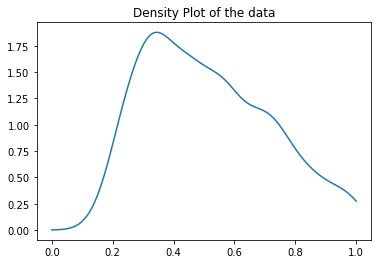

In [62]:
from scipy.stats import kde

data = each_query_score_2f
density = kde.gaussian_kde(data)
x = np.linspace(0,1,100)
y=density(x)

plt.plot(x, y)
plt.title("Density Plot of the data")
plt.show()

In [63]:
a_number = 0.2

larger_elements = [element for element in each_query_score_2f if element <= a_number]
number_of_elements = len(larger_elements)

print(number_of_elements)

31


In [64]:
number_of_elements / len(each_query_score_2f)

0.024351924587588374

In [65]:
top_1 = 0
top_3 = 0
top_5 = 0
top_10 = 0
top_30 = 0

missing_query_count = 0

not_matched = []

for user_input in range(len(dup_del_matched_list)):
    tmp = []
    top3_tmp = []
    if dup_del_matched_list[user_input][0] == '':
        # print("Missing query")
        missing_query_count += 1
        continue
    
    all_result = cosine_similarity_T(20, dup_del_matched_list[user_input][0])
    
    # if (all_result.iloc[]['Score'] <= 0.25):
    #     print("It's matched but not meet minimum threshold!!!")
    #     continue
    
    if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) and (all_result.iloc[0]['Score'] > 0.2):
        top_1 += 1
    if ((dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) and (all_result.iloc[0]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) and (all_result.iloc[1]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) and (all_result.iloc[2]['Score'] > 0.2)):
        top_3 += 1   
    if ((dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) and (all_result.iloc[0]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) and (all_result.iloc[1]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) and (all_result.iloc[2]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline']) and (all_result.iloc[3]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline']) and (all_result.iloc[4]['Score'] > 0.2)):
        top_5 += 1
    if ((dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) and (all_result.iloc[0]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) and (all_result.iloc[1]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) and (all_result.iloc[2]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline']) and (all_result.iloc[3]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline']) and (all_result.iloc[4]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[5]['headline']) and (all_result.iloc[5]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[6]['headline']) and (all_result.iloc[6]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[7]['headline']) and (all_result.iloc[7]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[8]['headline']) and (all_result.iloc[8]['Score'] > 0.2)) or ((dup_del_matched_list[user_input][1] == all_result.iloc[9]['headline']) and (all_result.iloc[9]['Score'] > 0.2)):
        top_10 += 1
    # if (dup_del_matched_list[user_input][1] == all_result.iloc[0]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[1]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[2]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[3]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[4]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[5]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[6]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[7]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[8]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[9]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[10]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[11]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[12]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[13]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[14]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[15]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[16]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[17]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[18]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[19]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[20]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[21]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[22]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[23]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[24]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[25]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[26]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[27]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[28]['headline']) or (dup_del_matched_list[user_input][1] == all_result.iloc[29]['headline']):
    #     top_30 += 1
    else:
        tmp.append(dup_del_matched_list[user_input][0])
        tmp.append(dup_del_matched_list[user_input][1])
        
        for i in range(20):
            tmp.append(all_result.iloc[i]['headline'])
            
        not_matched.append(tmp)
        

In [66]:
missing_query_count

0

In [67]:
top_1

827

In [68]:
top_3

1094

In [69]:
top_5

1172

In [70]:
top_10

1246

In [71]:
len(dup_del_matched_list)

1611

In [72]:
top_10/(len(dup_del_matched_list) - missing_query_count)

0.7734326505276226

In [73]:
not_matched

[['เชื้อ ‘ไวรัสโคโรนา’ อาจจะเป็นอาวุธชีวภาพที่คนสร้างขึ้นมา',
  'อย่าหลงเชื่อ! ‘อ.เจษฎ์’ ยัน ‘ไวรัสโคโรนา’ ถูกตัดต่อพันธุกรรมผสม HIV เป็นอาวุธชีวภาพ ไม่เป็นความจริง',
  'ชัวร์ก่อนแชร์ FACTSHEET : ไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'ชัวร์ก่อนแชร์ FACTSHEET : ไวรัสโคโรนาติดเชื้อผ่านดวงตาได้ จริงหรือ?',
  'คลิปสุดช็อค! ไวรัสโคโรนา ทำคนล้มทั้งยืน  ข่าวปลอม สร้างความเข้าใจผิด อย่าแชร์!',
  'ชัวร์ก่อนแชร์ FACTSHEET : กินอะไร? ช่วยป้องกันไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'ชัวร์ก่อนแชร์ FACTSHEET : ไวรัสโคโรนาในสุนัขและแมว',
  'ชัวร์ก่อนแชร์ FACTSHEET : มีการจดสิทธิบัตรไวรัสโคโรนาไว้แล้ว จริงหรือ?',
  'ข่าวปลอม อย่าแชร์! พบคนไทยเสียชีวิต 1 คน ติดไวรัสโคโรนามาจากเชียงใหม่',
  'ชัวร์ก่อนแชร์ FACTSHEET : การรักษาและป้องกันไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'ชัวร์ก่อนแชร์ FACTSHEET : “ไข้หวัดใหญ่” เทียบ “โคโรนาไวรัส 2019”',
  'พัทยาพบผู้ป่วยเสียชีวิตจากไวรัสโคโรนา 1 ราย ข่าวปลอมสร้างความปั่นป่วน\u200b หยุดแชร์!',
  'ชัวร์ก่อนแชร์ FACTSHEET : หน้ากาก-อาหารป้องกันไวรัสโคโรนาสายพันธุ์ใหม่ 2019',
  'อย่

In [74]:
len(not_matched)

365

In [75]:
top_10 + len(not_matched)

1611

In [76]:
len(dup_del_matched_list) - missing_query_count

1611